In [1]:
# 3rd party
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import lightkurve as lk
import re
import tensorflow as tf
from functools import partial
import time
import os


2025-07-17 16:57:25.590106: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-17 16:57:29.069592: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"  # Info/Warning messages not printed
tf.config.set_visible_devices([], "GPU")

In [3]:
np.random.seed(42)

In [4]:
tfrec_dir = Path("/nobackupp27/jochoa4/work_dir/data/datasets/TESS_exoplanet_dataset_07-11-2025_no_ntp_no_detrend/tfrecords/")

In [5]:
aux_tbl_pattern = 'data_tbl_????-????.csv'

In [6]:
def _merge_aux_tbls(tfrec_dir, aux_tbl_pattern):
    aux_tbl_fps = tfrec_dir.glob(aux_tbl_pattern)
    aux_tbls = []
    for aux_tbl_fp in aux_tbl_fps:
        aux_tbls.append(pd.read_csv(aux_tbl_fp))
    merged_aux_tbl = pd.concat(aux_tbls, ignore_index=True)
    return merged_aux_tbl

In [7]:
aux_tbl = _merge_aux_tbls(tfrec_dir, aux_tbl_pattern)

In [8]:
aux_tbl_fps = list(tfrec_dir.glob(aux_tbl_pattern))
aux_tbl_fps

[PosixPath('/nobackupp27/jochoa4/work_dir/data/datasets/TESS_exoplanet_dataset_07-11-2025_no_ntp_no_detrend/tfrecords/data_tbl_1354-1815.csv'),
 PosixPath('/nobackupp27/jochoa4/work_dir/data/datasets/TESS_exoplanet_dataset_07-11-2025_no_ntp_no_detrend/tfrecords/data_tbl_1286-1815.csv'),
 PosixPath('/nobackupp27/jochoa4/work_dir/data/datasets/TESS_exoplanet_dataset_07-11-2025_no_ntp_no_detrend/tfrecords/data_tbl_1705-1815.csv'),
 PosixPath('/nobackupp27/jochoa4/work_dir/data/datasets/TESS_exoplanet_dataset_07-11-2025_no_ntp_no_detrend/tfrecords/data_tbl_1125-1815.csv'),
 PosixPath('/nobackupp27/jochoa4/work_dir/data/datasets/TESS_exoplanet_dataset_07-11-2025_no_ntp_no_detrend/tfrecords/data_tbl_0242-1815.csv'),
 PosixPath('/nobackupp27/jochoa4/work_dir/data/datasets/TESS_exoplanet_dataset_07-11-2025_no_ntp_no_detrend/tfrecords/data_tbl_0815-1815.csv'),
 PosixPath('/nobackupp27/jochoa4/work_dir/data/datasets/TESS_exoplanet_dataset_07-11-2025_no_ntp_no_detrend/tfrecords/data_tbl_0975-1815

In [9]:
len(aux_tbl)

38311

In [10]:
aux_tbl.head()

,tce_uid,n_transit_examples,n_not_transit_examples,tfrec_fn,target_id,tce_plnt_num,numberOfPlanets,tce_num_transits,tce_num_transits_obs,tce_max_sngle_ev,...,tce_ptemp_stat,tce_insol,tce_cap_stat,tce_hap_stat,wst_depth,ruwe,mag_shift,disposition,disposition_source,matched_object
0,333868181-1-S14-19,3.0,3.0,raw_shard_1354-1815.tfrecord,333868181,1,2.0,3.0,3.0,484.062347,...,4.068892,43.687863,571.137291,52.221740,87434.109375,1.333139,4.0462,EB,Villanova,333868181-1
1,333868181-2-S14-19,0.0,0.0,raw_shard_1354-1815.tfrecord,333868181,2,2.0,2.0,2.0,274.766735,...,4.347059,17.337558,301.353353,36.206425,575.937434,1.333139,4.0462,UNK,NaN,NaN
2,333868181-1-S14-50,3.0,3.0,raw_shard_1354-1815.tfrecord,333868181,1,2.0,57.0,3.0,447.029510,...,3.838658,43.687808,590.941484,65.111420,73630.632812,1.333139,4.0462,EB,Villanova,333868181-1
3,333868181-2-S14-50,0.0,0.0,raw_shard_1354-1815.tfrecord,333868181,2,2.0,58.0,4.0,287.169673,...,4.498085,43.688131,412.442319,45.885943,516.440176,1.333139,4.0462,UNK,NaN,NaN
4,333868181-1-S14-55,4.0,4.0,raw_shard_1354-1815.tfrecord,333868181,1,2.0,64.0,5.0,482.526855,...,3.682832,43.687943,633.579354,54.447894,84436.281250,1.333139,4.0462,EB,Villanova,333868181-1


In [11]:
aux_tbl[['n_transit_examples', 'n_not_transit_examples', 'tce_depth']]

# aux_tbl = aux_tbl[aux_tbl["disposition"].isin(['EB', 'CP', 'KP'])]

,n_transit_examples,n_not_transit_examples,tce_depth
0,3.0,3.0,155788.868605
1,0.0,0.0,96500.632248
2,3.0,3.0,155125.420445
3,0.0,0.0,95679.056483
4,4.0,4.0,152832.819586
...,...,...,...
38306,0.0,0.0,3146.102229
38307,91.0,0.0,10170.634566
38308,73.0,0.0,9512.103945
38309,68.0,0.0,10259.617934


In [12]:
df = aux_tbl.copy()
df['n_total_examples'] = df.apply(lambda r: r['n_transit_examples'] + r['n_not_transit_examples'], axis=1)

In [13]:
print(f"\nSummary for dataset: ")
n_total_examples = df['n_total_examples'].sum()
n_transit_examples = df['n_transit_examples'].sum()
n_not_transit_examples = df['n_not_transit_examples'].sum()
print(f"n_total_examples: {df['n_total_examples'].sum()}")
print(f"n_transit_examples: {df['n_transit_examples'].sum()}")
print(f"n_not_transit_examples: {df['n_not_transit_examples'].sum()}")

for disp in df['disposition'].unique():
    disp_df = df[df['disposition'] == disp]

    disp_n_total_examples = disp_df['n_total_examples'].sum()
    disp_n_transit_examples = disp_df['n_transit_examples'].sum()
    disp_n_not_transit_examples = disp_df['n_not_transit_examples'].sum()
    
    print(f"\nSummary for {disp} in dataset: ")
    print(f"n_total_examples: {disp_n_total_examples} ({round(disp_n_total_examples / n_total_examples, 2) * 100} % )")
    print(f"n_transit_examples: {disp_n_transit_examples} ({round(disp_n_transit_examples / n_transit_examples, 2) * 100} % )")
    print(f"n_not_transit_examples: {disp_n_not_transit_examples} ({round(disp_n_not_transit_examples / n_not_transit_examples, 2) * 100} % )")


Summary for dataset: 
n_total_examples: 694541.0
n_transit_examples: 647508.0
n_not_transit_examples: 47033.0

Summary for EB in dataset: 
n_total_examples: 561426.0 (81.0 % )
n_transit_examples: 547930.0 (85.0 % )
n_not_transit_examples: 13496.0 (28.999999999999996 % )

Summary for UNK in dataset: 
n_total_examples: 0.0 (0.0 % )
n_transit_examples: 0.0 (0.0 % )
n_not_transit_examples: 0.0 (0.0 % )

Summary for NTP in dataset: 
n_total_examples: 0.0 (0.0 % )
n_transit_examples: 0.0 (0.0 % )
n_not_transit_examples: 0.0 (0.0 % )

Summary for KP in dataset: 
n_total_examples: 37623.0 (5.0 % )
n_transit_examples: 25489.0 (4.0 % )
n_not_transit_examples: 12134.0 (26.0 % )

Summary for NEB in dataset: 
n_total_examples: 38113.0 (5.0 % )
n_transit_examples: 33305.0 (5.0 % )
n_not_transit_examples: 4808.0 (10.0 % )

Summary for CP in dataset: 
n_total_examples: 55100.0 (8.0 % )
n_transit_examples: 39191.0 (6.0 % )
n_not_transit_examples: 15909.0 (34.0 % )

Summary for NPC in dataset: 
n_total

<Figure size 1200x600 with 0 Axes>

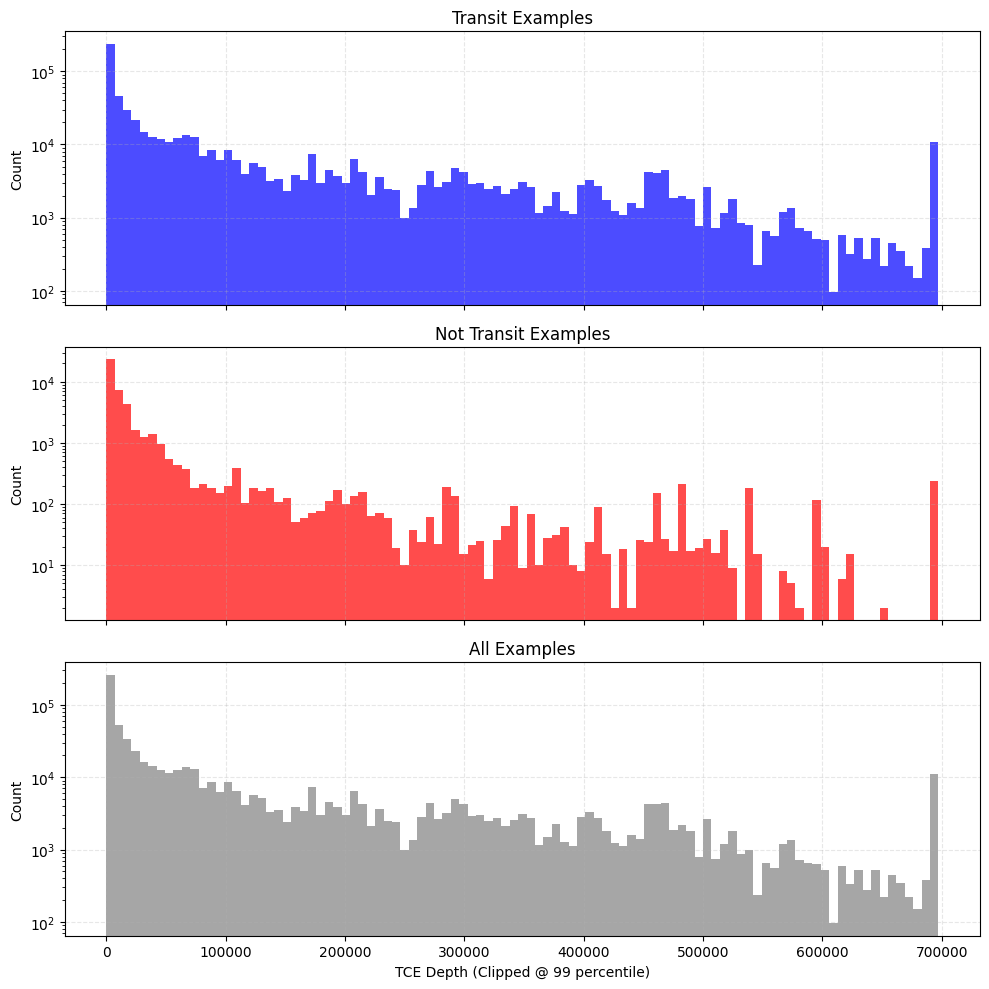

In [14]:
percentile = 99
depth_cap = np.percentile(df["tce_depth"], percentile)

df_clipped = df.copy()
df_clipped["tce_depth_clipped"] = df["tce_depth"].clip(upper=depth_cap)

transit_depths = df_clipped["tce_depth_clipped"].repeat(df_clipped["n_transit_examples"].astype(int))
not_transit_depths = df_clipped["tce_depth_clipped"].repeat(df_clipped["n_not_transit_examples"].astype(int))
all_depths = pd.concat([transit_depths, not_transit_depths])

plt.figure(figsize=(12, 6))
bins = np.linspace(0, depth_cap, 100)

fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

axs[0].hist(transit_depths, bins=bins, color='blue', alpha=0.7)
axs[0].set_title("Transit Examples")
axs[0].set_yscale('log')

axs[1].hist(not_transit_depths, bins=bins, color='red', alpha=0.7)
axs[1].set_title("Not Transit Examples")
axs[1].set_yscale('log')

axs[2].hist(all_depths, bins=bins, color='gray', alpha=0.7)
axs[2].set_title("All Examples")
axs[2].set_yscale('log')

for ax in axs:
    ax.set_ylabel("Count")
    ax.grid(True, linestyle='--', alpha=0.3)

axs[-1].set_xlabel(f"TCE Depth (Clipped @ {percentile} percentile)")
plt.tight_layout()
plt.show()


In [15]:
df['disposition'].unique()

array(['EB', 'UNK', 'NTP', 'KP', 'NEB', 'CP', 'NPC'], dtype=object)

# Looking at filtered table

In [27]:
filtered_tfrec_dir = Path("/nobackupp27/jochoa4/work_dir/data/datasets/TESS_exoplanet_dataset_07-11-2025_no_ntp_no_detrend_split_norm_filtered/tfrecords")


In [28]:
# [train | shard 0137] removed 1 / 27 examples due to disposition.
# NOTE PROBLEM is that if no shards removed it doesn't print.
def parse_removal_log(log_path):
    removed_total = 0
    total_examples = 0

    # Regex pattern to match lines like:
    # [train | shard 0133] removed 50 / 416 examples due to disposition.
    pattern = re.compile(r"removed\s+(\d+)\s*/\s*(\d+)\s+examples")

    with open(log_path, "r") as f:
        for line in f:
            match = pattern.search(line)
            if match:
                removed = int(match.group(1))
                total = int(match.group(2))
                removed_total += removed
                total_examples += total

    print(f"Total examples: {total_examples}")
    print(f"Total removed: {removed_total}")
    print(f"Fraction removed: {removed_total / total_examples:.4f}")

log_file = Path("/nobackupp27/jochoa4/work_dir/data/logging/pbs_jobs/filter_TESS_exoplanet_dataset_07-11-2025_no_ntp_no_detrend_split_norm.txt")
parse_removal_log(log_file)


Total examples: 643049
Total removed: 450635
Fraction removed: 0.7008


In [29]:
694541.0 - 643049

51492.0

In [30]:
def process_shard(shard_num, input_dir, num_shards):
    try:
        shard_num = str(shard_num).zfill(4)
        shards_summary = {
                'total_count': 0,
                'test':[],
                'train':[],
                'val':[],
            }
        
        for split_name in ["train", "test", "val"]:
            input_tfrec_fp = (
                input_dir
                / split_name
                / f"norm_{split_name}_shard_{shard_num}-{num_shards}.tfrecord"
            )
            if not input_tfrec_fp.exists():
                print(f"input_tfrec_fp: {str(input_tfrec_fp)} does not exist")
                continue
            print(f"Processing: {str(input_tfrec_fp.name)}")

            tfrec_dataset = tf.data.TFRecordDataset(str(input_tfrec_fp))

            for str_record in tfrec_dataset:
                example = tf.train.Example()
                example.ParseFromString(str_record.numpy())
                shards_summary['total_count'] += 1
                uid = (
                    example.features.feature["uid"]
                    .bytes_list.value[0]
                    .decode("utf-8")
                )
                tce_uid = uid.split('_t_')[0]
                disposition = (
                    example.features.feature["disposition"]
                    .bytes_list.value[0]
                    .decode("utf-8")
                )
                label = (
                    example.features.feature["label"]
                    .bytes_list.value[0]
                    .decode("utf-8")
                )
                transit_example = example.features.feature["transit_example"].bytes_list.value[0].decode('utf-8')

                tce_depth = example.features.feature["tce_depth"].float_list.value[0]
                tce_duration = example.features.feature["tce_duration"].float_list.value[0]
                tce_period = example.features.feature["tce_period"].float_list.value[0]
                example_summary = {
                    'uid': uid,
                    'tce_uid': tce_uid,
                    'disposition': disposition,
                    "label":label,
                    "transit_example":transit_example,
                    "tce_depth":tce_depth,
                    "tce_duration":tce_duration,
                    "tce_period":tce_period,
                }
                shards_summary[split_name].append(
                    example_summary
                )
        return shards_summary
    except Exception as e:
        print(f"Error processing shard {shard_num}: {e}")

In [31]:

num_shards = 1815

start = time.time()
print(f"Beginning processing shards")
shard_summary_map = {}
for shard_num in range(1, num_shards + 1):
    try:
        shard_summary = process_shard(shard_num, filtered_tfrec_dir, num_shards)
        shard_summary_map[shard_num] = shard_summary
    except Exception as e:
        print(f"ERROR: unexpected exception: {e}")
        continue
end = time.time()
print(f"Finished processing all shards in {end - start} seconds")

Beginning processing shards
Processing: norm_train_shard_0001-1815.tfrecord
Processing: norm_test_shard_0001-1815.tfrecord
Processing: norm_val_shard_0001-1815.tfrecord
Processing: norm_train_shard_0002-1815.tfrecord
Processing: norm_test_shard_0002-1815.tfrecord
Processing: norm_val_shard_0002-1815.tfrecord
Processing: norm_train_shard_0003-1815.tfrecord
Processing: norm_test_shard_0003-1815.tfrecord
Processing: norm_val_shard_0003-1815.tfrecord
Processing: norm_train_shard_0004-1815.tfrecord
Processing: norm_test_shard_0004-1815.tfrecord
Processing: norm_val_shard_0004-1815.tfrecord
Processing: norm_train_shard_0005-1815.tfrecord
Processing: norm_test_shard_0005-1815.tfrecord
Processing: norm_val_shard_0005-1815.tfrecord
Processing: norm_train_shard_0006-1815.tfrecord
Processing: norm_test_shard_0006-1815.tfrecord
Processing: norm_val_shard_0006-1815.tfrecord
Processing: norm_train_shard_0007-1815.tfrecord
Processing: norm_test_shard_0007-1815.tfrecord
Processing: norm_val_shard_0007

In [32]:
total_examples = 0
for shard_num, shard_summary in shard_summary_map.items():
    total_examples += shard_summary['total_count']
print(f"Found {total_examples} examples in dataset after filtering")

Found 243906 examples in dataset after filtering


Expected

In [33]:
df.head()

,tce_uid,n_transit_examples,n_not_transit_examples,tfrec_fn,target_id,tce_plnt_num,numberOfPlanets,tce_num_transits,tce_num_transits_obs,tce_max_sngle_ev,...,wst_depth,ruwe,mag_shift,disposition,disposition_source,matched_object,n_total_examples,filt_n_transit_examples,filt_n_not_transit_examples,filt_n_total_examples
0,333868181-1-S14-19,3.0,3.0,raw_shard_1354-1815.tfrecord,333868181,1,2.0,3.0,3.0,484.062347,...,87434.109375,1.333139,4.0462,EB,Villanova,333868181-1,6.0,0.0,3.0,3.0
1,333868181-2-S14-19,0.0,0.0,raw_shard_1354-1815.tfrecord,333868181,2,2.0,2.0,2.0,274.766735,...,575.937434,1.333139,4.0462,UNK,NaN,NaN,0.0,0.0,0.0,0.0
2,333868181-1-S14-50,3.0,3.0,raw_shard_1354-1815.tfrecord,333868181,1,2.0,57.0,3.0,447.029510,...,73630.632812,1.333139,4.0462,EB,Villanova,333868181-1,6.0,0.0,3.0,3.0
3,333868181-2-S14-50,0.0,0.0,raw_shard_1354-1815.tfrecord,333868181,2,2.0,58.0,4.0,287.169673,...,516.440176,1.333139,4.0462,UNK,NaN,NaN,0.0,0.0,0.0,0.0
4,333868181-1-S14-55,4.0,4.0,raw_shard_1354-1815.tfrecord,333868181,1,2.0,64.0,5.0,482.526855,...,84436.281250,1.333139,4.0462,EB,Villanova,333868181-1,8.0,0.0,4.0,4.0


In [34]:
df['tce_depth']

0        155788.868605
1         96500.632248
2        155125.420445
3         95679.056483
4        152832.819586
             ...      
38306      3146.102229
38307     10170.634566
38308      9512.103945
38309     10259.617934
38310     10980.196050
Name: tce_depth, Length: 38311, dtype: float64

In [38]:
df['filt_n_transit_examples'] = df.apply(lambda r: r['n_transit_examples'] if r['tce_depth'] > 100000 and r['disposition'] in ['EB', 'CP', 'KP'] else 0.0, axis=1)
df['filt_n_not_transit_examples'] = df.apply(lambda r: r['n_not_transit_examples'] if r['disposition'] in ['EB', 'CP', 'KP'] else 0.0, axis=1)
df['filt_n_total_examples'] = df.apply(lambda r: r['filt_n_transit_examples'] + r['filt_n_not_transit_examples'], axis=1)

In [39]:
df['filt_n_total_examples'].sum()

243906.0

# Expected examples match


In [40]:
total_examples_key = "filt_n_total_examples"
transit_example_key = "filt_n_transit_examples"
not_transit_example_key = "filt_n_not_transit_examples"
print(f"\nSummary for dataset: ")
n_total_examples = df[total_examples_key].sum()
n_transit_examples = df[transit_example_key].sum()
n_not_transit_examples = df[not_transit_example_key].sum()
print(f"n_total_examples: {df[total_examples_key].sum()}")
print(f"n_transit_examples: {df[transit_example_key].sum()}")
print(f"n_not_transit_examples: {df[not_transit_example_key].sum()}")

for disp in df['disposition'].unique():
    disp_df = df[df['disposition'] == disp]

    disp_n_total_examples = disp_df[total_examples_key].sum()
    disp_n_transit_examples = disp_df[transit_example_key].sum()
    disp_n_not_transit_examples = disp_df[not_transit_example_key].sum()
    
    print(f"\nSummary for {disp} in dataset: ")
    print(f"n_total_examples: {disp_n_total_examples} ({round(disp_n_total_examples / n_total_examples, 2) * 100} % )")
    print(f"n_transit_examples: {disp_n_transit_examples} ({round(disp_n_transit_examples / n_transit_examples, 2) * 100} % )")
    print(f"n_not_transit_examples: {disp_n_not_transit_examples} ({round(disp_n_not_transit_examples / n_not_transit_examples, 2) * 100} % )")


Summary for dataset: 
n_total_examples: 243906.0
n_transit_examples: 202367.0
n_not_transit_examples: 41539.0

Summary for EB in dataset: 
n_total_examples: 214828.0 (88.0 % )
n_transit_examples: 201332.0 (99.0 % )
n_not_transit_examples: 13496.0 (32.0 % )

Summary for UNK in dataset: 
n_total_examples: 0.0 (0.0 % )
n_transit_examples: 0.0 (0.0 % )
n_not_transit_examples: 0.0 (0.0 % )

Summary for NTP in dataset: 
n_total_examples: 0.0 (0.0 % )
n_transit_examples: 0.0 (0.0 % )
n_not_transit_examples: 0.0 (0.0 % )

Summary for KP in dataset: 
n_total_examples: 12271.0 (5.0 % )
n_transit_examples: 137.0 (0.0 % )
n_not_transit_examples: 12134.0 (28.999999999999996 % )

Summary for NEB in dataset: 
n_total_examples: 0.0 (0.0 % )
n_transit_examples: 0.0 (0.0 % )
n_not_transit_examples: 0.0 (0.0 % )

Summary for CP in dataset: 
n_total_examples: 16807.0 (7.000000000000001 % )
n_transit_examples: 898.0 (0.0 % )
n_not_transit_examples: 15909.0 (38.0 % )

Summary for NPC in dataset: 
n_total_e